In [1]:
import os 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns

from data_exploration import *

# Initial Data Exploration

The following code explores the data splits of Goldman et al. (2022), looking at relationships between feature set overlap, training size, and other properties. 

In [12]:
def plot_stats(x, y, xlab, ylab, savefig=None):
    """Helper function to make the plots aesthetic and run stats"""
    
    # Convert the input to arrays so we can get a line of best fit 
    x = np.asarray(x)
    y = np.asarray(y)
    a, b = np.polyfit(x, y, 1)
    
    # Plot the points and the line of best fit 
    plt.scatter(x, y, color="indigo", alpha=0.2, s=70)
    plt.plot(x, a*x+b, linestyle="-", color="indigo", linewidth=1)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(f"{ylab} vs. {xlab}")
    if savefig is None:
        plt.show()
    else:
        plt.savefig(savefig, dpi=500)
    
    # Run the statistics 
    pearson = stats.pearsonr(x, y)
    spearman = stats.spearmanr(x, y)
    kendall_tau = stats.kendalltau(x, y)
    for name, stat in [("Pearson's R", pearson), ("Spearman", spearman), ("Kendall's Tau", kendall_tau)]:
        print(f"{name}:\t{stat.statistic :.3f},\t p = {stat.pvalue}")

def run_correlation(PATH_TO_DATA, funct1, funct2):
    """Run a single correlation between two functions over the data"""
    xs = []
    ys = []
    langs = []
    for language_family in [l for l in os.listdir(PATH_TO_DATA) if "." not in l]:
        for language in set([f.split(".")[0] for f in os.listdir(f"{PATH_TO_DATA}/{language_family}")]):
            xs.append(funct1(f"{PATH_TO_DATA}/{language_family}/{language}"))
            ys.append(funct2(f"{PATH_TO_DATA}/{language_family}/{language}"))
            langs.append(f"{language_family}/{language}")
    return xs, ys, langs

## Featureset Overlap

The following shows the relationship between full featureset overlap and training size in the Goldman data. 
There seems to be little relationship, and as expected based on the splitting methodology most of the languages have 100% feature overlap. 
However, there are several outliers, the most notable of which is Ludic, with a feature overlap of just 0.303.

Pearson's R:	0.068,	 p = 0.5214148242235089
Spearman:	-0.254,	 p = 0.015637164504902358
Kendall's Tau:	-0.207,	 p = 0.014535193521698355


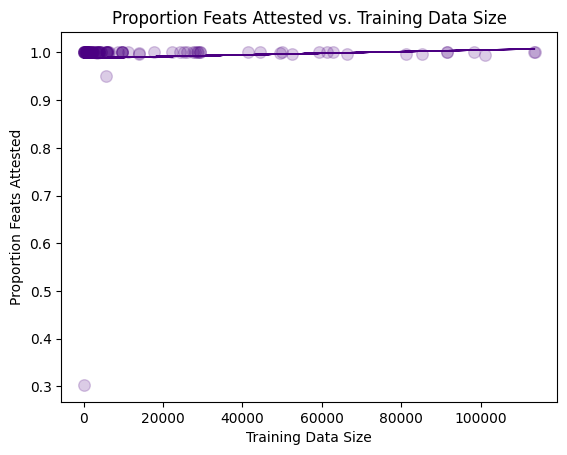

In [14]:
PATH_TO_DATA = "LemmaSplitting/LemmaSplitData"

trn_sz, overlap, languages = run_correlation(PATH_TO_DATA, train_size, feature_overlap)
plot_stats(trn_sz, overlap, "Training Data Size", "Proportion Feats Attested", savefig="../writeup/figs/feats_attested.png")

Clearly, if we are splitting my lemmas and have complete paradigms, we _should_ (except in cases of gaps, but even then sufficient data should remedy this) have 100% feature overlap at all times. 
However, the graph above clearly demonstrates that this is not the case. 
We thus investigate the causes of overlap being less than 100%. 
Initial exploration shows that dips in overlap are usually caused by a few lemmas in test that appear in _much_ bigger paradigms than words of the same part of speech in train. 
To quantify this, we measure the mean paradigm size for the `training` (train + dev) data, the `test` data, and the `problematic lemmas` in the test data, which are defined as any lemma in the test data that occurs with at least one feature set not attested in train. 

In [4]:
for ovlp, lang in zip(overlap, languages):
    if ovlp < 1:
        print(lang, ovlp)
        investigate_feature_overlap(f"{PATH_TO_DATA}/{lang}")

romance/vec 0.9960362400906002
POS: V
	 mean train paradigm size:	 47.282, (stdev: 4.185, n = 294, max = 57)
	 mean test paradigm size:	 47.730, (stdev: 3.214, n = 74)
	 mean problematic lemma size:	 54.000, (stdev: 7.000, n = 2)


tungusic/evn 0.9501404494382022
POS: N
	 mean train paradigm size:	 1.717, (stdev: 2.190, n = 1859, max = 34)
	 mean test paradigm size:	 1.684, (stdev: 2.191, n = 437)
	 mean problematic lemma size:	 6.000, (stdev: 8.116, n = 15)


POS: V
	 mean train paradigm size:	 2.345, (stdev: 3.881, n = 797, max = 42)
	 mean test paradigm size:	 2.567, (stdev: 5.496, n = 201)
	 mean problematic lemma size:	 6.742, (stdev: 11.862, n = 31)


POS: ADJ
	 mean train paradigm size:	 1.192, (stdev: 0.789, n = 308, max = 11)
	 mean test paradigm size:	 1.066, (stdev: 0.248, n = 91)
	 mean problematic lemma size:	 1.200, (stdev: 0.400, n = 5)


germanic/nob 0.9985689753863767
POS: ADJ
	 mean train paradigm size:	 2.402, (stdev: 1.004, n = 667, max = 5)
	 mean test paradigm siz

Problematic difference: 	mean: 4.825 (stdev: 8.948)
Max difference: 	mean: 0.119 (stdev: 0.332)
T-test: 5.801 (p: 3.708933370244261e-08)


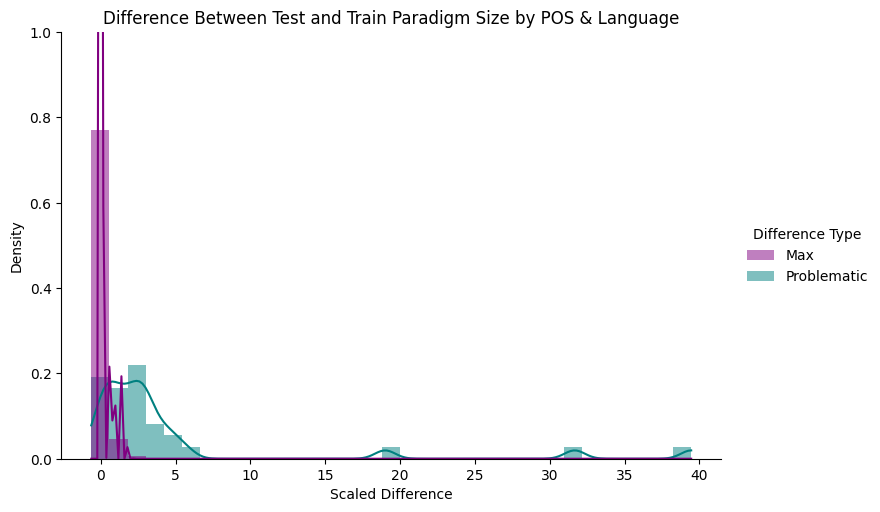

In [17]:
differences = []
labels = []
for ovlp, lang in zip(overlap, languages):
    if ovlp < 1: 
        res = investigate_feature_overlap(f"{PATH_TO_DATA}/{lang}", verbose=False)
        for pos in res:
            if "problematic" in res[pos]:
                train = res[pos]["train"][0]
                test = res[pos]["problematic"][0]
                difference = (test - train) / train
                differences.append(difference)
                labels.append("Problematic")
    else:
        res = investigate_feature_overlap(f"{PATH_TO_DATA}/{lang}", verbose=False)
        for pos in res:
            if "test" in res[pos]:
                train = res[pos]["train"][0]
                test = res[pos]["test"][-1]
                difference = (test - train) / train
                differences.append(difference)
                labels.append("Max")
                

df = pd.DataFrame({"Difference Type": labels, "Scaled Difference": differences})
sns.displot(df, 
            palette=["purple", "teal"], 
            linewidth=0, 
            alpha=0.5, 
            x="Scaled Difference", 
            hue="Difference Type", 
            kde=True, 
            kde_kws={"bw_method": 0.05, "bw_adjust": 1.5}, 
            binwidth=1.2, 
            common_norm=False, 
            stat="density",
            aspect=1.5
           )
plt.ylim(0.0, 1)
plt.title("Difference Between Test and Train Paradigm Size by POS & Language")
plt.savefig("../writeup/figs/percent_increase.png", dpi=500, bbox_inches='tight')

difference_problematic = df.loc[df['Difference Type'] == "Problematic"]
difference_max = df.loc[df['Difference Type'] == "Max"]

for data in [difference_problematic, difference_max]:
    label = list(data["Difference Type"])[0]
    data = data["Scaled Difference"]
    print(f"{label} difference: \tmean: {np.average(data):.3f} (stdev: {np.std(data):.3f})")

ttest = stats.ttest_ind(difference_problematic["Scaled Difference"], difference_max["Scaled Difference"])
print(f"T-test: {ttest.statistic :.3f} (p: {ttest.pvalue})")

In [11]:
### difference_good = []
difference_bad = []
for ovlp, lang in zip(overlap, languages):
    #print(lang)
    res = investigate_feature_overlap(f"{PATH_TO_DATA}/{lang}", verbose=False)
    for pos in res:
        if "test" in res[pos]:
            train = res[pos]["train"][0]
            test = res[pos]["test"][0]
            difference = (test - train) / train
            if difference < 100:
                if ovlp < 1:
                    difference_bad.append(difference)
                else:
                    difference_good.append(difference)
print(sum(difference_good)/len(difference_good))
print(sum(difference_bad)/len(difference_bad))
plt.hist(difference_good, bins = 15)
plt.hist(difference_bad, bins = 15)
plt.show() 
stats.ttest_ind(difference_good, difference_bad)

NameError: name 'difference_good' is not defined

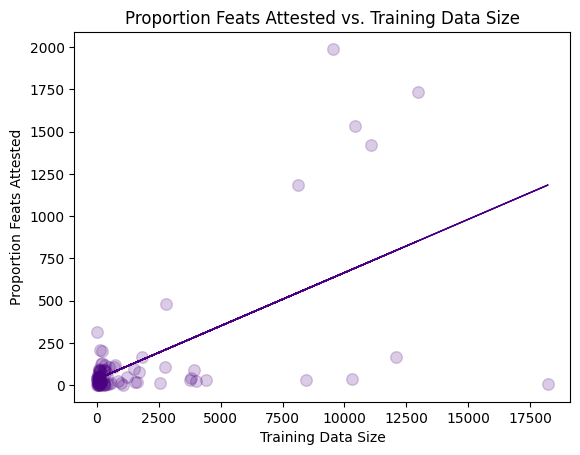

Pearson's R:	0.606,	 p = 2.40148120416708e-10
Spearman:	0.274,	 p = 0.00907795261075298
Kendall's Tau:	0.201,	 p = 0.005225968592352


In [5]:
lemmas, features, languages = run_correlation(PATH_TO_DATA, unique_lemmas, unique_featuresets)
plot_stats(lemmas, features, "Training Data Size", "Proportion Feats Attested")

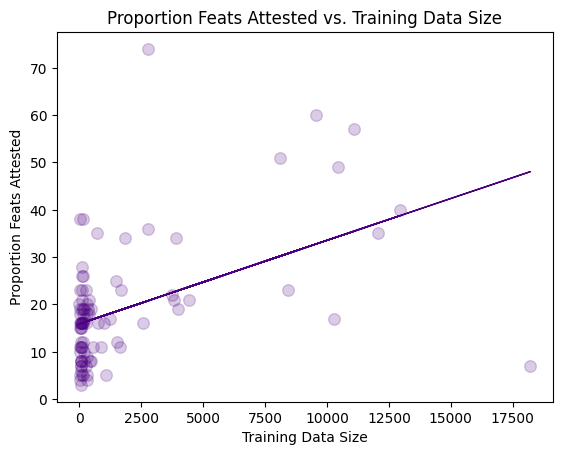

Pearson's R:	0.719,	 p = 1.4560429587787086e-15
Spearman:	0.867,	 p = 2.1661677218065572e-28
Kendall's Tau:	0.726,	 p = 4.7381303534837157e-23


In [9]:
lemmas, features, languages = run_correlation(PATH_TO_DATA, unique_lemmas, unique_features)
plot_stats(lemmas, features, "Training Data Size", "Proportion Feats Attested")